In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import seaborn as sns
import random

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# PCA

In [2]:
# Define path
data_path = "../data/"

In [3]:
# Get data and convert to float matrix
df = pd.read_csv(data_path + 'data_sys2_filter.csv').drop(columns=['system', 'date_rounded', 'hour','moment_day'])
data_features_float = df.copy()

# Correlation analysis

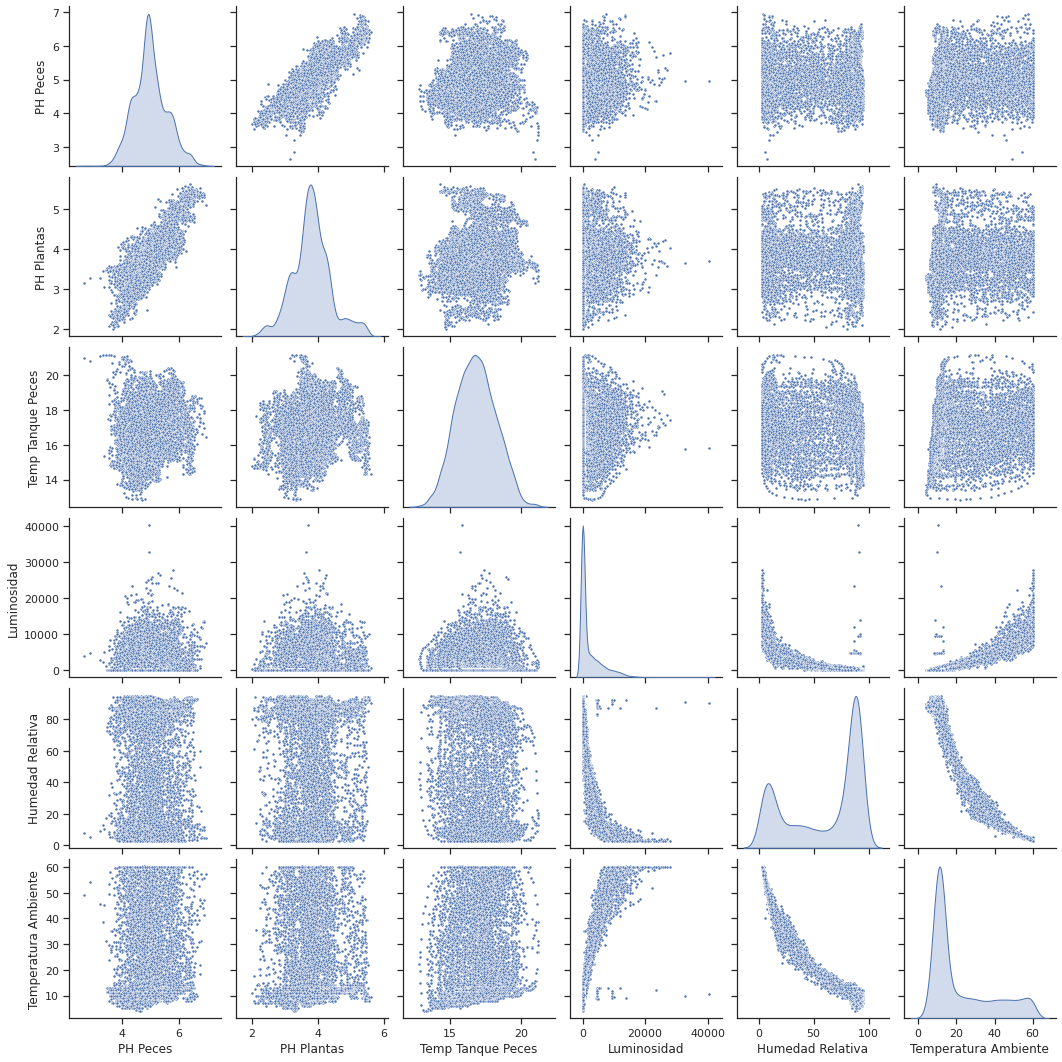

In [4]:
sns.set(context='notebook', style='ticks')

# Correlation matrix
g1 = sns.heatmap(data_features_float.corr().round(2), vmin=-1, vmax=1, cmap='viridis', linewidth=0.5, linecolor='k', annot=True)
g1.set_title('Correlation of variables')
G2 = sns.pairplot(data_features_float, diag_kind='kde', markers='.')
plt.show()

# Fit PCA total number of components

In [5]:
pca_pipeline = Pipeline([('scale', StandardScaler()),('pca', PCA())]) # Define estimator object 
pca_pipeline.fit(data_features_float)
pca_only = pca_pipeline.named_steps["pca"]

## Selection of number of components

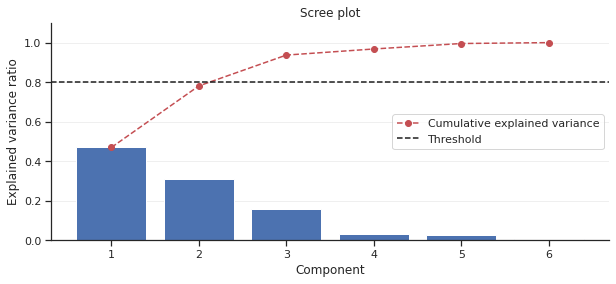

In [6]:
thres = 0.8 # proportion of variance explained to select number of components
component_count = np.arange(data_features_float.shape[1])+1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(x=component_count, height=pca_only.explained_variance_ratio_)
ax.plot(component_count, np.cumsum(pca_only.explained_variance_ratio_), label='Cumulative explained variance', color='r', linestyle='--', marker='o')

# figure lay-out
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Component')
ax.set_title('Scree plot')
ax.set_ylim(0,1.1)
ax.axhline(thres, linestyle='--', color='k', label = "Threshold") # threshold
ax.legend()

ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

# Final PCA

In [7]:
pca_pipeline = Pipeline([('scale', StandardScaler()),('pca', PCA(n_components = 3))]) # Define estimator object 
pca_pipeline.fit(data_features_float)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=3))])

In [8]:
def biplot(pca, X, scaled:bool=False, labels:list=None, pc_h = 1, pc_v = 2, pipeline_pca_name = None):
    """
    This function will generate a biplot of your data.
    
    INPUT:
    --------
    pca: sklean estimator (fitted)
    X: The dataset on which a pca analysis should be performed
    scaled: standard scale the data or not
    labels: list with the names of the variables
    pc_h: pc for the horizontal axis
    pc_v: pc for the vertical axis
    """
    
    
    score = pca.transform(X)
    
    if isinstance(pca, Pipeline):      
    
        pca = pca.named_steps[pipeline_pca_name]      
 
    
    coeff = pca.components_[[pc_h-1,pc_v-1], :].T
    
    xs = score[:,pc_h-1]
    ys = score[:,pc_v-1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(14,10))
    plt.scatter(xs * scalex,ys * scaley, alpha=0.1, s=10)
    for i in range(n):
        if labels is None:
            plt.annotate("Var"+str(i+1), xy=(0, 0), xytext=(coeff[i,0], coeff[i,1]),  color = 'tab:red', arrowprops=dict(arrowstyle='<-', color='tab:orange'), bbox=dict(fc="white", ec="b", lw=1))
        else:
            plt.annotate(labels[i], xy=(0, 0), xytext=(coeff[i,0], coeff[i,1]), color = 'tab:red', arrowprops=dict(arrowstyle='<-', color='tab:orange', linewidth=1.5), bbox=dict(fc='white',ec="b", lw=1, alpha=0.3))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f"PC{pc_h} ({pca.explained_variance_ratio_[pc_h-1]*100:.1f}%)")
    plt.ylabel(f"PC{pc_v} ({pca.explained_variance_ratio_[pc_v-1]*100:.1f}%)")

## Biplot

According to the previous scree plot, visualize the biplot up the optimal number of components

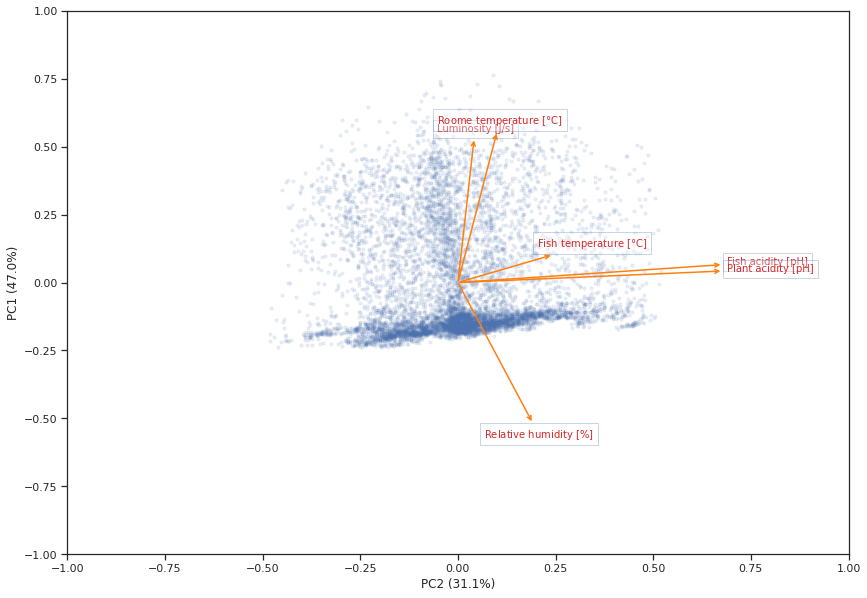

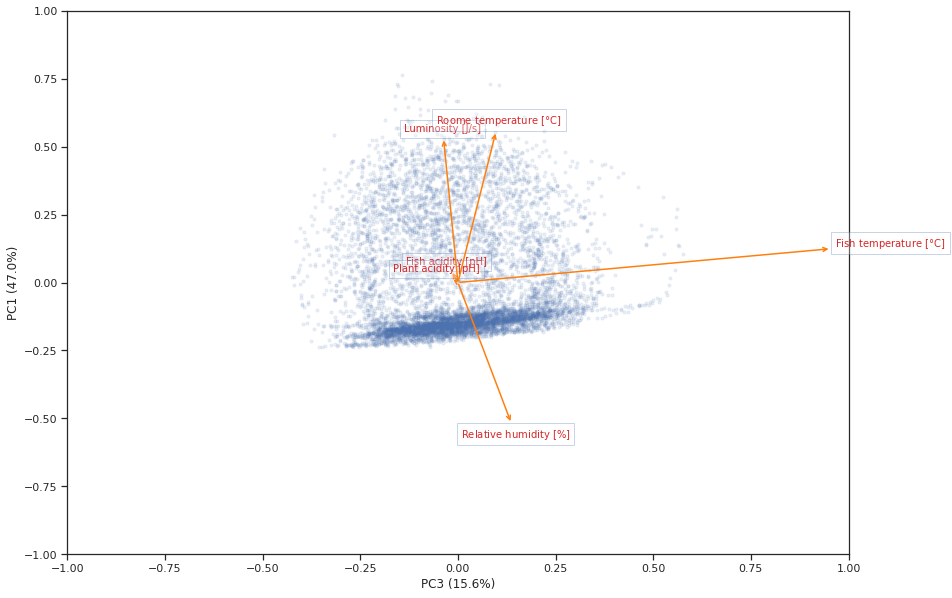

In [9]:
english_vars = ['Fish acidity [pH]', 'Plant acidity [pH]', 'Fish temperature [$\degree$C]', 'Luminosity [J/s]', 'Relative humidity [$\%$]', 'Roome temperature [$\degree$C]']
biplot(pca_pipeline, data_features_float, scaled=True, labels = english_vars, pc_h = 2, pc_v = 1, pipeline_pca_name = "pca")
biplot(pca_pipeline, data_features_float, scaled=True, labels = english_vars, pc_h = 3, pc_v = 1, pipeline_pca_name = "pca")

## Scores plot

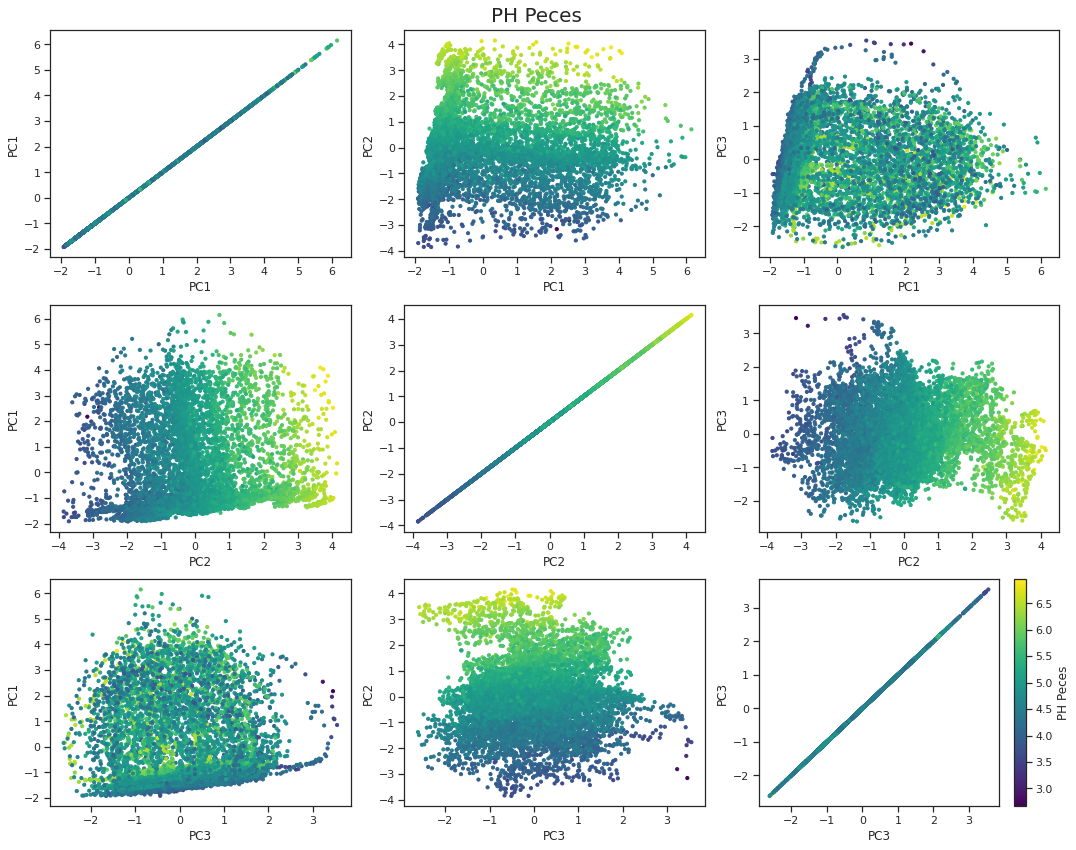

In [10]:
yvar = "PH Peces"
scores = pd.DataFrame(pca_pipeline.transform(data_features_float))
scores.columns = [f"PC{i+1}" for i in range(scores.shape[1])]
scores[f"{yvar}_color"] = pd.cut(data_features_float[yvar], bins = 10).values
scores[yvar] = np.asarray(data_features_float[yvar])
# g = sns.pairplot(scores, diag_kind='kde', hue = f"{yvar}_color")
# plt.show()

fig, axs = plt.subplots(pca_pipeline["pca"].n_components,pca_pipeline["pca"].n_components,figsize = (15,12))    
for i in range(pca_pipeline["pca"].n_components*pca_pipeline["pca"].n_components):
    
    ax_i = i//pca_pipeline["pca"].n_components
    ax_j = i%pca_pipeline["pca"].n_components   
    ax = axs[ax_i, ax_j].scatter(scores[f"PC{ax_i+1}"],
                            scores[f"PC{ax_j+1}"],
                           c = scores[yvar], cmap='viridis', s=10)
    
    axs[ax_i, ax_j].set_xlabel(f"PC{ax_i+1}")
    axs[ax_i, ax_j].set_ylabel(f"PC{ax_j+1}")

fig.suptitle(yvar, fontsize=20)
cbar = fig.colorbar(ax,cmap=mtply.cm.viridis)
cbar.set_label(yvar)
plt.tight_layout()
plt.show()

## Loadings

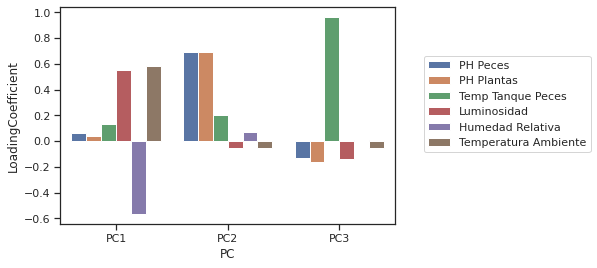

In [11]:
loadings = pd.DataFrame(pca_pipeline.named_steps["pca"].components_.T)
loadings.columns = [f"PC{i+1}" for i in range(loadings.shape[1])]
loadings_melted = loadings.copy()
loadings.index = data_features_float.columns
loadings_melted["yvar"] = data_features_float.columns
loadings_melted = pd.melt(loadings_melted, id_vars=["yvar"], var_name= "PC", value_name = "LoadingCoefficient")

sns.barplot(data=loadings_melted, x = "PC", y = "LoadingCoefficient", hue = "yvar")
plt.legend(bbox_to_anchor=(1.6,0.8))
plt.show()

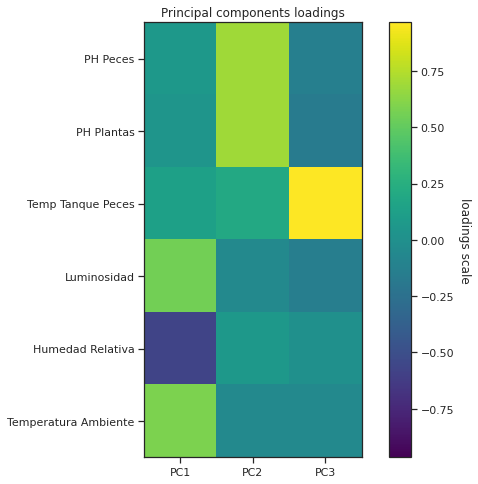

In [12]:
vmax = np.amax(np.abs(np.asarray(loadings)))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(np.asarray(loadings), cmap="viridis", vmax=vmax, vmin=-vmax)
ax.set_yticks(np.arange(len(data_features_float.columns)))
ax.set_yticklabels(data_features_float.columns)
ax.set_xticks(np.arange(len(loadings.columns)))
ax.set_xticklabels(loadings.columns)
ax.set_title("Principal components loadings")
cbar = fig.colorbar(im,cmap=mtply.cm.viridis)
cbar.set_label("loadings scale", rotation=-90, va='bottom')
plt.show()

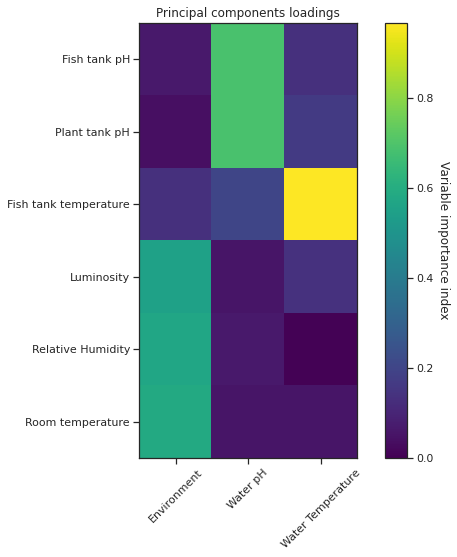

In [13]:
vmax = np.amax(np.abs(np.asarray(loadings)))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(np.abs(np.asarray(loadings)), cmap="viridis", vmax=vmax, vmin=0)
ax.set_yticks(np.arange(len(data_features_float.columns)))
# ax.set_yticklabels(data_features_float.columns)
ax.set_yticklabels(['Fish tank pH', 'Plant tank pH', 'Fish tank temperature', 'Luminosity', 'Relative Humidity', 'Room temperature'])
ax.set_xticks(np.arange(len(loadings.columns)))
# ax.set_xticklabels(loadings.columns)
ax.set_xticklabels(['Environment', 'Water pH', 'Water Temperature'], rotation=45)
ax.set_title("Principal components loadings")
cbar = fig.colorbar(im,cmap=mtply.cm.viridis)
cbar.set_label("Variable importance index", rotation=-90, va='bottom')
plt.show()

# Publication Figures
## Figure 2 - PCA analysis

In [29]:
sns.set(context='notebook', style='ticks')

In [22]:
from adjustText import adjust_text

In [23]:
def biplot(pca, X, ax, labels:list=None, pc_h = 1, pc_v = 2, pipeline_pca_name = None):   
    score = pca.transform(X)
    if isinstance(pca, Pipeline):         
        pca = pca.named_steps[pipeline_pca_name]      
  
    coeff = pca.components_[[pc_h-1,pc_v-1], :].T  
    xs = score[:,pc_h-1]
    ys = score[:,pc_v-1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    ax.scatter(xs * scalex,ys * scaley, alpha=0.1, s=2, c='black')
    
    cmap = plt.cm.get_cmap('tab10')
    texts = []
    for i in range(n):
        ax.annotate('', xy=(0, 0), xytext=(coeff[i,0], coeff[i,1]), arrowprops=dict(arrowstyle='<-', color=cmap(i), linewidth=1.5))
        texts.append(ax.text(coeff[i,0],coeff[i,1], labels[i], color=cmap(i), ha='center', bbox=dict(fc='white', ec='black', alpha=0.5)))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    named_components = ['Environment', 'Water acidity', 'Water Temperature']
    ax.set_xlabel(named_components[pc_h-1] + f"\nPC{pc_h} ({pca.explained_variance_ratio_[pc_h-1]*100:.1f}%)")
    ax.set_ylabel(named_components[pc_v-1] + f"\nPC{pc_v} ({pca.explained_variance_ratio_[pc_v-1]*100:.1f}%)")
    adjust_text(texts, ax=ax, expand_text=(1.05, 1.2))

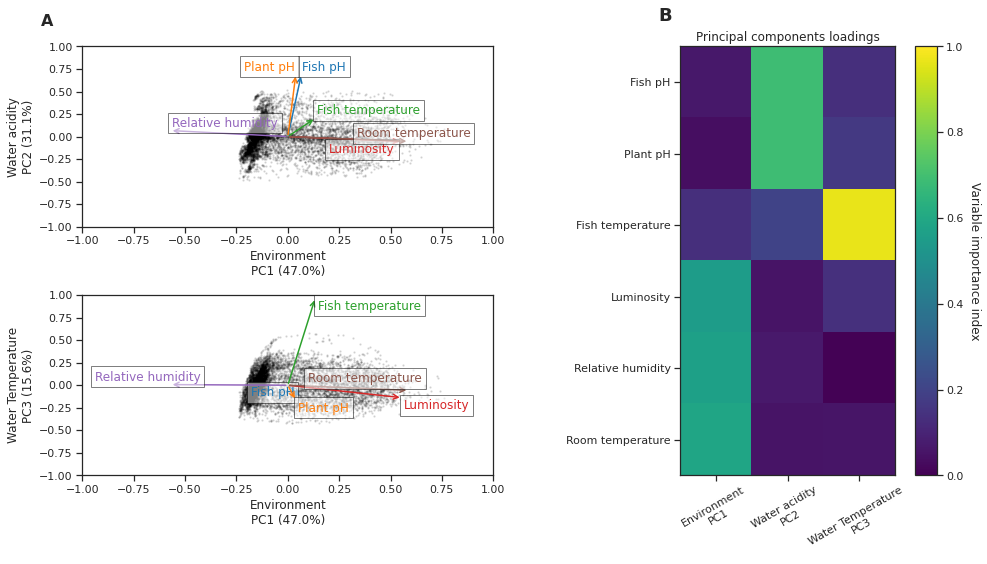

In [50]:
english_vars = ['Fish pH', 'Plant pH', 'Fish temperature', 'Luminosity', 'Relative humidity', 'Room temperature']

f, axes = plt.subplot_mosaic([[1, 2], [3, 2]],
                              figsize=(14,8))#, gridspec_kw={'hspace':0.6, 'wspace':0.25})
biplot(pca_pipeline, data_features_float, axes[1], labels = english_vars, pc_h = 1, pc_v = 2, pipeline_pca_name = "pca")
biplot(pca_pipeline, data_features_float, axes[3], labels = english_vars, pc_h = 1, pc_v = 3, pipeline_pca_name = "pca")

im = axes[2].imshow(np.abs(np.asarray(loadings)), cmap="viridis", vmax=1, vmin=0)
axes[2].set_yticks(np.arange(len(data_features_float.columns)))
axes[2].set_yticklabels(english_vars)
axes[2].set_xticks(np.arange(len(loadings.columns)))
axes[2].set_xticklabels(['Environment\nPC1', 'Water acidity\nPC2', 'Water Temperature\nPC3'], rotation=30)
axes[2].set_title("Principal components loadings")

axes[1].text(-0.1, 1.1, 'A', transform=axes[1].transAxes,va='bottom', fontsize=16, fontweight='bold')
axes[2].text(-0.1, 1.05, 'B', transform=axes[2].transAxes,va='bottom', fontsize=18, fontweight='bold')


cbar = fig.colorbar(im, cmap=plt.cm.viridis)
cbar.set_label("Variable importance index", rotation=-90, va='bottom')
plt.tight_layout()
plt.savefig('../figures/fig2_pca.png', dpi=300)
plt.savefig('../figures/fig2_pca.pdf')
plt.show()